In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

!pip install rouge/requirements.txt
!pip install rouge-score

     |████████████████████████████████| 3.1 MB 5.0 MB/s 
     |████████████████████████████████| 895 kB 41.6 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 61 kB 536 kB/s 
     |████████████████████████████████| 3.3 MB 36.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 298 kB 5.3 MB/s 
     |████████████████████████████████| 243 kB 31.3 MB/s 
     |████████████████████████████████| 132 kB 49.9 MB/s 
     |████████████████████████████████| 1.1 MB 40.8 MB/s 
     |████████████████████████████████| 160 kB 51.0 MB/s 
     |████████████████████████████████| 271 kB 44.5 MB/s 
     |████████████████████████████████| 192 kB 47.1 MB/s 
     |████████████████████████████████| 123 kB 5.4 MB/s 
     |████████████████████████████████| 131 kB 37.5 MB/s 
     |████████████████████████████████| 8.4 

In [4]:
%cd '/content/drive/MyDrive/CS685/'

/content/drive/MyDrive/CS685


In [5]:
import os
import time
# from google.colab import drive

import json
import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, \
GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from datasets import load_dataset
from helper import format_time, rouge
from data import GPT2Dataset, preprocessing, split_data
from plots import loss_curves

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="/content/drive/MyDrive/CS685" )

Downloading:   0%|          | 0.00/3.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Using custom data configuration en-c080136eb0615511


0 examples [00:00, ? examples/s]

Dataset covid_qa_ucsd downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_ucsd/en-c080136eb0615511/1.0.0/2a15b6e8fdc7cee91951d8f20ac2b26ede79fbef988919fbde22dbb97bf4df81. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
cd_df = covid_dialog['train'].to_pandas()
print(len(cd_df))
cd_df.head()

572


,dialogue_id,dialogue_url,dialogue_turns
0,1,https://www.icliniq.com/qa/covid-19/i-have-cou...,"{'speaker': [0, 1, 0, 1], 'utterance': ['I hav..."
1,2,https://www.icliniq.com/qa/covid-19/i-have-a-l...,"{'speaker': [0, 1, 0, 1, 0, 1, 0, 1], 'utteran..."
2,3,https://www.icliniq.com/qa/coronavirus/can-cor...,"{'speaker': [0, 1], 'utterance': ['Can Coronav..."
3,4,https://www.icliniq.com/qa/covid-19/i-have-chi...,"{'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ..."
4,5,https://www.healthcaremagic.com/premiumquestio...,"{'speaker': [0, 1], 'utterance': ['Does COVID-..."


In [8]:
qa_df = preprocessing(cd_df)
text = qa_df.text.copy()

qa_df.head()

/content/data.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_fields = np.transpose(np.array(all_fields).reshape((4, -1)))


,id,encoder,decoder,text
0,0,[I have cough with no travel history. Is this ...,"[Hello, I understand your concern. I just have...",[I have cough with no travel history. Is this ...
1,0,[I have cough with no travel history. Is this ...,"[Hi, I would recommend you take n-acetylcystei...",[I have cough with no travel history. Is this ...
2,1,[I have a little fever with no history of fore...,"[Hello, I can understand your concern.In my op...",[I have a little fever with no history of fore...
3,1,[I have a little fever with no history of fore...,"[Hi, yes, upload in this query only. I will se...",[I have a little fever with no history of fore...
4,1,[I have a little fever with no history of fore...,"[Hi, I can understand your concern. I have gon...",[I have a little fever with no history of fore...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


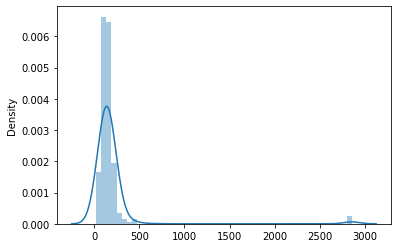

In [9]:
doc_lengths = []

for bio in text:
  
    # get rough token count distribution
    tokens = nltk.word_tokenize(bio[0])

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [10]:
torch.cuda.empty_cache()

In [11]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")


Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [12]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token

unique_vals = qa_df.id[len(qa_df)-1]

# Split into training and validation sets
train_size = int(0.8 * unique_vals)
val_size = int(0.1 * unique_vals)
test_size = unique_vals - train_size - val_size

train_split, val_split, test_split = split_data(qa_df, [train_size, val_size, test_size])

train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)
test_split.reset_index(drop=True, inplace=True)

print(train_split.head())

print("length of dataset: " + str(unique_vals))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

train_dataset = GPT2Dataset(train_split, tokenizer, max_length=768)
val_dataset = GPT2Dataset(val_split, tokenizer, max_length=768)
test_dataset = GPT2Dataset(test_split, tokenizer, max_length=768)

    id  ...                                               text
0  516  ...  [I have a dry cough and a sore throat. I do no...
1  116  ...  [What is the treatment for tuberculosis and pn...
2  233  ...  [If I leave Covid 19 infected product in fridg...
3  393  ...  [Hi ,  Can I use Oralcon birth control pills e...
4  250  ...  [I am a 20/F. Went to the dentist & had a root...

[5 rows x 4 columns]
length of dataset: 571
  456 training samples
   57 validation samples
   58 test samples


In [13]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [14]:
useCuda = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cuda


In [15]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# if torch.cuda.is_available() and useCuda:
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [16]:
# some parameters I cooked up that work reasonably well
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [18]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [19]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[5].to(device)
        b_labels = batch[5].to(device)
        b_masks = batch[6].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    min_length = 50,
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[5].to(device)
        b_labels = batch[5].to(device)
        b_masks = batch[6].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 1 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    228. Loss: 0.5193015336990356.   Elapsed: 0:01:42.
0: 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    228. Loss: 0.5056973099708557.   Elapsed: 0:03:24.
0: 

  Average training loss: 0.87
  Training epoch took: 0:03:52

Running Validation...
  Validation Loss: 0.71
  Validation took: 0:00:09

Training complete!
Total training took 0:04:01 (h:mm:ss)


In [20]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.87,0.71,0:03:52,0:00:09


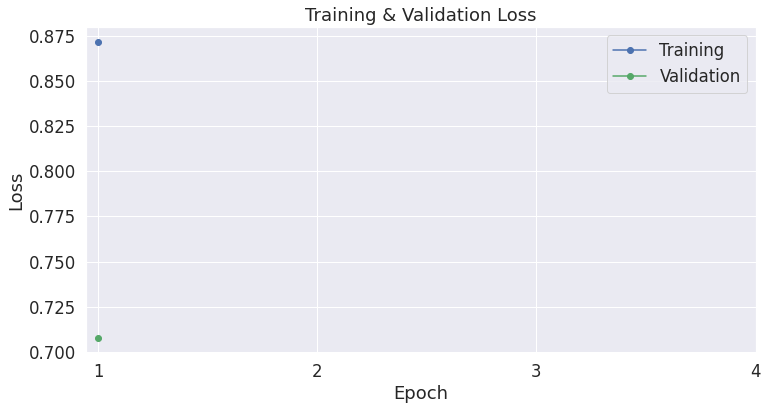

In [21]:
loss_curves(df_stats)

In [22]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [36]:
model = model.to('cpu')
rougeL = []
rougeLsum = []
rouge1 = []
rouge2 = []

for i, encoder_input in enumerate(test_dataset.input_ids[0:5]):
    encoder_input = encoder_input[encoder_input != 50256]
    encoder_input = torch.reshape(encoder_input, (1, -1))

    predicted = model.generate(encoder_input, max_length=1000, min_length=50, return_dict=True)
    
    decoded_input = tokenizer.decode(encoder_input[0], skip_special_tokens=True)
    decoded_prediction = tokenizer.decode(predicted[:, encoder_input.shape[-1]:][0], skip_special_tokens=True)
    decoded_ground = tokenizer.decode(test_dataset.decoder_ids[i], skip_special_tokens=True)
    
    # print("input: ")
    # print(decoded_input)
    # print("prediction: ")
    # print(decoded_prediction)
    # print("ground: ")
    # print(decoded_ground)
    rouge_dict = rouge(decoded_prediction, decoded_ground)
    rougeL.append(rouge_dict["rougeL"])
    rougeLsum.append(rouge_dict["rougeLsum"])
    rouge1.append(rouge_dict["rouge1"])
    rouge2.append(rouge_dict["rouge2"])

avg_rougeL_p = sum([rougeL[i].precision for i in range(len(rougeL))])/len(rougeL)
avg_rougeL_r = sum([rougeL[i].recall for i in range(len(rougeL))])/len(rougeL)
avg_rougeL_f = sum([rougeL[i].fmeasure for i in range(len(rougeL))])/len(rougeL)

avg_rougeLsum_p = sum([rougeLsum[i].precision for i in range(len(rougeLsum))])/len(rougeLsum)
avg_rougeLsum_r = sum([rougeLsum[i].recall for i in range(len(rougeLsum))])/len(rougeLsum)
avg_rougeLsum_f = sum([rougeLsum[i].fmeasure for i in range(len(rougeLsum))])/len(rougeLsum)

avg_rouge1_p = sum([rouge1[i].precision for i in range(len(rouge1))])/len(rouge1)
avg_rouge1_r = sum([rouge1[i].recall for i in range(len(rouge1))])/len(rouge1)
avg_rouge1_f = sum([rouge1[i].fmeasure for i in range(len(rouge1))])/len(rouge1)

avg_rouge2_p = sum([rouge2[i].precision for i in range(len(rouge2))])/len(rouge2)
avg_rouge2_r = sum([rouge2[i].recall for i in range(len(rouge2))])/len(rouge2)
avg_rouge2_f = sum([rouge2[i].fmeasure for i in range(len(rouge2))])/len(rouge2)

print("RougeL - precision: " + str(avg_rougeL_p) + ", recall: " + str(avg_rougeL_r) + ", fmeasure: " + str(avg_rougeL_f))
print("RougeLsum - precision: " + str(avg_rougeLsum_r) + ", recall: " + str(avg_rougeLsum_r) + ", fmeasure: " + str(avg_rougeLsum_f))
print("Rouge1 - precision: " + str(avg_rouge1_p) + ", recall: " + str(avg_rouge1_r) + ", fmeasure: " + str(avg_rouge1_f))
print("Rouge2 - precision: " + str(avg_rouge2_p) + ", recall: " + str(avg_rouge2_r) + ", fmeasure: " + str(avg_rouge2_f))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


RougeL - precision: 0.00909090909090909, recall: 0.06666666666666667, fmeasure: 0.016
RougeLsum - precision: 0.06666666666666667, recall: 0.06666666666666667, fmeasure: 0.016
Rouge1 - precision: 0.00909090909090909, recall: 0.06666666666666667, fmeasure: 0.016
Rouge2 - precision: 0.0, recall: 0.0, fmeasure: 0.0


In [37]:
model = model.to('cpu')
step = 0
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      print("How well did I answer the question? (See the five-point scale in the readme.)")
      input("Answer: ")
      print("Thanks! How fluent were my answers? (See the five-point scale in the readme.)")
      input("Answer: ")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, return_dict=True)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))

>> User:i have a cough


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT:  now
>> User:i am done talking


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


DialoGPT:  to you
>> User:I am done talking
DialoGPT: Ok bye bye
How well did I answer the question? (See the five-point scale in the readme.)
Answer: 1
Thanks! How fluent were my answers? (See the five-point scale in the readme.)
Answer: 1


In [ ]:
print(model.device)

print(bot_input_ids1.device)

# Can't be different

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))
